In [47]:
import pygrib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import pandas as pd
import plotly.graph_objects as go

import datetime as dt
from dateutil.relativedelta import relativedelta

In [48]:
file_name = "adaptor.mars.internal-1622846426.3351655-26320-29-d3ec277c-a906-49aa-8941-9746ec5f867d.grib"
t = 508

We consider the region within the coordinates 55.5 x 17.5 - 40.5 x -5 as Western Europe. We only take the corresponding data to reduce the amount of data considered.

In [49]:
fig = go.Figure()

long_value = [17.5, 17.5, -5, -5]
lat_value = [55.5, 40.5, 55.5, 40.5]

fig.add_trace(go.Scattergeo(
    lon = long_value,
    lat = lat_value,
    mode = 'markers',
    marker = dict(
        size = 7,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )
))
fig.update_layout(
        geo_scope='europe',
    )
fig.show()

To make sure that we take the correct values from the matrix, plot both the real world coordinates (that serve as the boundary for the area we consider) and the indexes we use to take the data from our numpy array (that serve as the "boundary" for the part of the matrix we consider.
We can see, that the following two plots match. Hence, the indexes 136x700 - 196x790 can to slice the data necessary for us from all data arrays.

In [50]:
fig = go.Figure()

long_value = [17.5, 17.5, -5, -5]
lat_value = [55.5, 40.5, 55.5, 40.5]

fig.add_trace(go.Scattergeo(
    lon = long_value,
    lat = lat_value,
    mode = 'markers',
    marker = dict(
        size = 7,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )
))
fig.show()

136 196
700 790


<IPython.core.display.Javascript object>


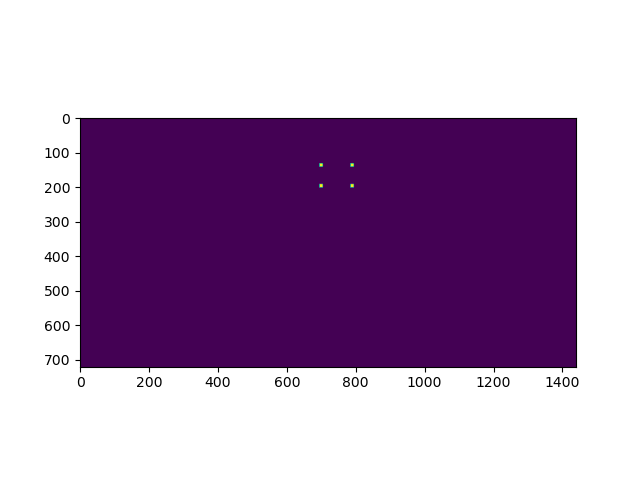

In [51]:
syn_data = np.zeros((721, 1440))


# Lat values: 40.5, 55.5
# Lon values: -5, 17.5

"""
Transform the real world coordinates into indexes to read the values from the data that are 
important for our investigations. 
For lateral values: The coordinates go from 90°N (+90) to 90°S (-90). Hence, we subtract the
lat coordinate from 90 to have the distance (in °-units) from the north pole. Multiply this 
with 4, as we have a resolution of 1/4.
For longitude values: The coordinates go from 180°W (-180) to 180°O (+180). Hence, we subtract the
lon coordinate from 180 to have the distance (in °-units) from the coordinate with the same latitude 
value and longitude value = 180°W. Multiply this, as well, with 4.
"""
idx1_lat = int(90 - 55.5) * 4
idx2_lat = int(90 - 40.5) * 4
idx1_lon = 720 + 4 * (-5)
idx2_lon = int(720 + 4 * 17.5)

print(idx1_lat, idx2_lat)
print(idx1_lon, idx2_lon)


syn_data[idx1_lat-5 : idx1_lat+5, idx1_lon-5:idx1_lon+5] = 1
syn_data[idx1_lat-5 : idx1_lat+5, idx2_lon-5:idx2_lon+5] = 1
syn_data[idx2_lat-5 : idx2_lat+5, idx1_lon-5:idx1_lon+5] = 1
syn_data[idx2_lat-5 : idx2_lat+5, idx2_lon-5:idx2_lon+5] = 1

plt.imshow(syn_data)
plt.show()

Read the data from western europe and store it in a numpy array.

In [61]:
%%time

gr = pygrib.open(file_name)

dim_lat = idx2_lat - idx1_lat
dim_lon = idx2_lon - idx1_lon

data = np.zeros((t, dim_lat, dim_lon))

for idx, g in enumerate(gr):
    data[idx, :] = g.values[idx1_lat : idx2_lat, idx1_lon : idx2_lon]

Wall time: 6.84 s


<IPython.core.display.Javascript object>


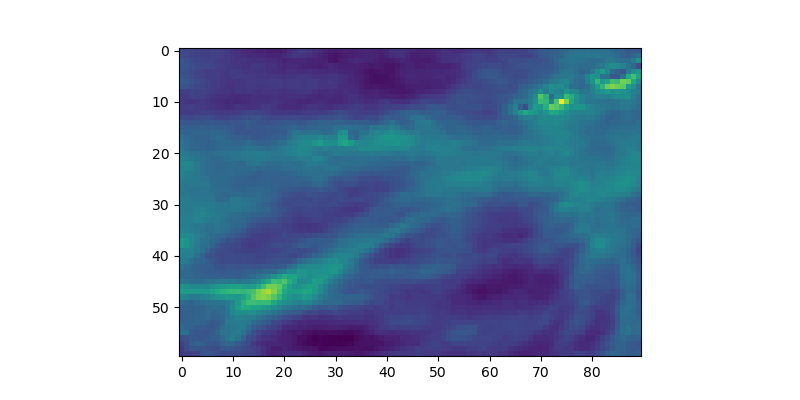

In [66]:
%matplotlib notebook    

import time

def update(t, data):
    time.sleep(0.1)
    ax.imshow(data[t])
    return None

fig, ax = plt.subplots(1, 1, figsize=[8, 4])
ITERATIONS = data.shape[0]

anim = FuncAnimation(fig, update, frames=ITERATIONS, interval=50, blit=True, 
                     fargs=([data]))

The visualization of the data does not appear to be smooth. However, since the data comes with a monthly resolution, this is not too suprising. However, some parts of the data seems to be poorly reanalyzed (especially in the upper right). This could lead to wrong conclusions in our results (we might detect communities even if there are none).


Next, store the data to save some space.

In [63]:
np.save('data.npy', data)